# Install & Import

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings

In [2]:
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings("ignore")

# Utils

In [3]:
def get_dataset(dataset_name, random_state=1):
    """Get dataset."""
    target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
    df = get_data(dataset_name, verbose=False).sample(frac=1, random_state=random_state)
    X, y = df.drop(target_name, axis=1), df[target_name]
    y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
    num_features = X.columns[X.apply(is_numeric)].tolist()
    cat_features = [c for c in X.columns if c not in num_features]
    return X, y, num_features, cat_features

In [4]:
def is_numeric(x):
    """Check whether an object is numeric."""
    try:
        x+0
        return True
    except:
        return False

In [5]:
def calibration_report(y_true, y_prob, n_bins, strategy="quantile"):

    if strategy == "quantile":
        quantiles = np.linspace(0, 1, n_bins + 1)
        bin_edges = np.percentile(y_prob, quantiles * 100)
    elif strategy == "uniform":
        y_prob_min, y_prob_max = y_prob.min(), y_prob.max()
        bin_edges = np.linspace(y_prob_min, y_prob_max, n_bins + 1)

    bin_edges[0] -= 1e-8
    bin_id = np.digitize(y_prob, bin_edges, right = True) - 1

    bin_count = np.bincount(bin_id)
    bin_y_sum = np.bincount(bin_id, weights = y_true)
    bin_prob_sum = np.bincount(bin_id, weights = y_prob)

    bin_nonzero = bin_count > 0
    bin_count = bin_count[bin_nonzero]
    bin_y_sum = bin_y_sum[bin_nonzero]
    bin_prob_sum = bin_prob_sum[bin_nonzero]

    bin_y_mean = bin_y_sum / bin_count
    bin_prob_mean = bin_prob_sum / bin_count
    ece = np.sum(np.abs(bin_prob_mean - bin_y_mean) * bin_count) / np.sum(bin_count)

    return ece, bin_y_mean, bin_prob_mean, bin_count, bin_edges

In [6]:
def calibration_reports(y_true, y_prob, n_bins, strategy="quantile", n_iter=1_000):

    reports = []

    for iter in range(n_iter):
        np.random.seed(iter)
        y_true_simul = (np.random.uniform(0, 1, size=len(y_prob)) < y_prob).astype(int)
        report = calibration_report(y_true=y_true_simul, y_prob=y_prob, n_bins=n_bins, strategy=strategy)
        reports.append(report)

    return reports

# Simulated data

In [7]:
n = 15_000
X, y = make_classification(
    n_samples = n, n_features = 20, n_informative = 10,
    n_redundant = 10, weights = [.9, .1], random_state = 0
)
X_train, X_valid, X_test = X[:int(n/3)], X[int(n/3):int(n*2/3)], X[int(n*2/3):]
y_train, y_valid, y_test = y[:int(n/3)], y[int(n/3):int(n*2/3)], y[int(n*2/3):]

# Models

In [8]:
model = DecisionTreeClassifier(max_depth=5).fit(X=X_train, y=y_train)
raw_proba_valid = model.predict_proba(X_valid)[:, 1]
calibrator = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = "clip").fit(X=raw_proba_valid, y=y_valid)
raw_proba_test = model.predict_proba(X_test)[:, 1]
cal_proba_test = calibrator.predict(raw_proba_test)

In [9]:
df = pd.concat([pd.Series(raw_proba_test, name="proba"), pd.Series(y_test, name="y")], axis=1)
ix = [(df["proba"] - i).abs().idxmin() for i in [.02, .03, .05, .10, .20, .50, .70, .90]]
df = df.loc[ix].sample(frac=1, random_state=1).reset_index(drop=True)
df["y simul (1)"] = df["proba"].apply(lambda x: np.random.choice([0,1],p=[1-x,x]))
df["y simul (2)"] = df["proba"].apply(lambda x: np.random.choice([0,1],p=[1-x,x]))
df["y simul (3)"] = df["proba"].apply(lambda x: np.random.choice([0,1],p=[1-x,x]))
df["..."] = "..."

# Results

In [10]:
df.head(10)

,proba,y,y simul (1),y simul (2),y simul (3),...
0,0.938776,1,1,1,1,...
1,0.059041,0,0,0,0,...
2,0.023969,0,0,0,0,...
3,0.692308,1,0,0,0,...
4,0.021739,0,0,0,0,...
5,0.199074,0,0,1,0,...
6,0.083333,1,0,0,0,...
7,0.533333,1,1,0,0,...


In [11]:
n_bins = 20
strategy = "quantile"
raw_actual_report = calibration_report(y_test, raw_proba_test, n_bins=n_bins, strategy=strategy)
raw_simul_reports = calibration_reports(y_test, raw_proba_test, n_bins=n_bins, strategy=strategy)
cal_actual_report = calibration_report(y_test, cal_proba_test, n_bins=n_bins, strategy=strategy)
cal_simul_reports = calibration_reports(y_test, cal_proba_test, n_bins=n_bins, strategy=strategy)

In [12]:
ece, bin_y_mean, bin_prob_mean, bin_count, bin_edges = raw_actual_report
bin_edges = sorted(set(bin_edges))

In [13]:
summary = pd.concat([
    pd.Series([pd.Interval(round(l,3), round(r,3)) for l, r in zip(bin_edges[:-1], bin_edges[1:])], name="bin edges"),
    pd.Series(bin_prob_mean, name="proba mean"),
    pd.Series(bin_y_mean, name="y mean"),
    pd.Series(bin_count, name="count"),
], axis=1)
summary.index.name = "bin"

In [14]:
summary

,bin edges,proba mean,y mean,count
bin,,,,
0,"(-0.0, 0.022]",0.018674,0.022951,305
1,"(0.022, 0.024]",0.023969,0.036088,2577
2,"(0.024, 0.059]",0.059041,0.118280,279
3,"(0.059, 0.06]",0.059701,0.066865,673
4,"(0.06, 0.12]",0.116192,0.146154,260
5,"(0.12, 0.182]",0.182266,0.141631,233
6,"(0.182, 0.199]",0.199074,0.183206,262
7,"(0.199, 0.533]",0.429945,0.431034,232
8,"(0.533, 1.0]",0.910539,0.759777,179


In [15]:
((summary["proba mean"] - summary["y mean"]).abs() * summary["count"] / summary["count"].sum()).sum()

0.020508117157246986

# Plots

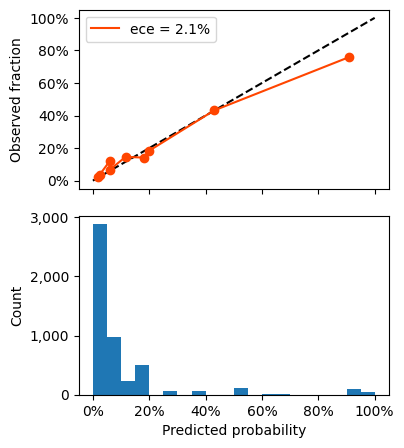

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
plt.subplots_adjust(hspace=.15)

axs[0].plot([0, 1], [0, 1], linestyle = "--", color="black")
axs[0].plot(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10,
    label=f"ece = {raw_actual_report[0]:.1%}")
axs[0].scatter(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10)
axs[1].hist(raw_proba_test, bins=np.linspace(0,1,21))
axs[0].legend()
axs[0].set_yticks(np.linspace(0,1,6))
axs[0].set_yticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[0].set_ylabel("Observed fraction")
axs[1].set_xticks(np.linspace(0,1,6))
axs[1].set_xticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[1].set_xlabel("Predicted probability")
axs[1].set_yticklabels([f"{int(x):,}" for x in axs[1].get_yticks()])
axs[1].set_ylabel("Count")
fig.savefig("toy_raw.png", dpi=200, bbox_inches="tight")

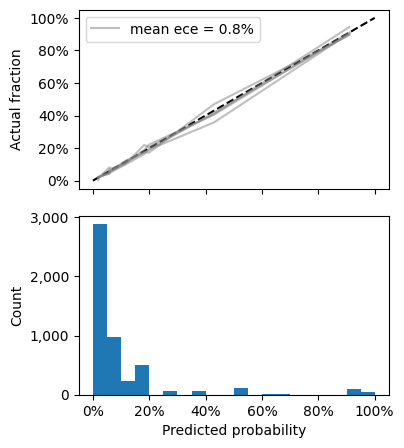

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
plt.subplots_adjust(hspace=.15)

pvalue = np.mean(np.array([s[0] for s in raw_simul_reports]) > raw_actual_report[0])

axs[0].plot([0, 1], [0, 1], linestyle = "--", color="black")
#axs[0].plot(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10,
#    label=f"ece = {raw_actual_report[0]:.1%}\n(p-value = {pvalue:.1%})")
#axs[0].scatter(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10)

for enum, raw_simul_report in enumerate(raw_simul_reports[:5]):
    label = f"mean ece = {np.mean([s[0] for s in raw_simul_reports]):.1%}" if enum == 0 else None
    axs[0].plot(raw_simul_report[2], raw_simul_report[1], color="grey", alpha=.5, label=label)

axs[1].hist(raw_proba_test, bins=np.linspace(0,1,21))
axs[0].legend()
axs[0].set_yticks(np.linspace(0,1,6))
axs[0].set_yticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[0].set_ylabel("Actual fraction")
axs[1].set_xticks(np.linspace(0,1,6))
axs[1].set_xticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[1].set_xlabel("Predicted probability")
axs[1].set_yticklabels([f"{int(x):,}" for x in axs[1].get_yticks()])
axs[1].set_ylabel("Count")

fig.savefig("toy_raw_only_simul.png", dpi=200, bbox_inches="tight")

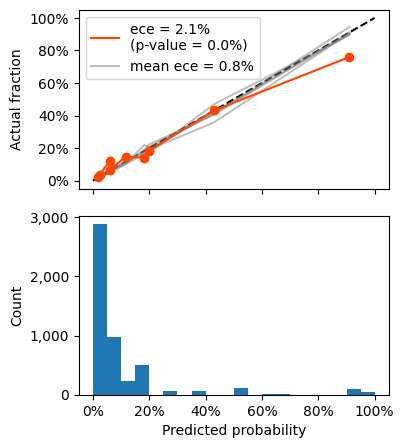

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
plt.subplots_adjust(hspace=.15)

pvalue = np.mean(np.array([s[0] for s in raw_simul_reports]) > raw_actual_report[0])

axs[0].plot([0, 1], [0, 1], linestyle = "--", color="black")
axs[0].plot(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10,
    label=f"ece = {raw_actual_report[0]:.1%}\n(p-value = {pvalue:.1%})")
axs[0].scatter(raw_actual_report[2], raw_actual_report[1], color="orangered", zorder=10)

for enum, raw_simul_report in enumerate(raw_simul_reports[:5]):
    label = f"mean ece = {np.mean([s[0] for s in raw_simul_reports]):.1%}" if enum == 0 else None
    axs[0].plot(raw_simul_report[2], raw_simul_report[1], color="grey", alpha=.5, label=label)

axs[1].hist(raw_proba_test, bins=np.linspace(0,1,21))
axs[0].legend()
axs[0].set_yticks(np.linspace(0,1,6))
axs[0].set_yticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[0].set_ylabel("Actual fraction")
axs[1].set_xticks(np.linspace(0,1,6))
axs[1].set_xticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[1].set_xlabel("Predicted probability")
axs[1].set_yticklabels([f"{int(x):,}" for x in axs[1].get_yticks()])
axs[1].set_ylabel("Count")

fig.savefig("toy_raw_simul.png", dpi=200, bbox_inches="tight")

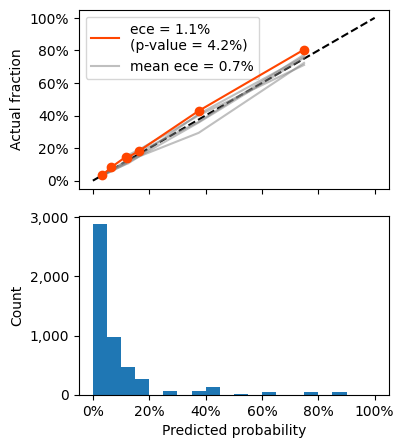

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
plt.subplots_adjust(hspace=.15)

pvalue = np.mean(np.array([s[0] for s in cal_simul_reports]) > cal_actual_report[0])

axs[0].plot([0, 1], [0, 1], linestyle = "--", color="black")
axs[0].plot(cal_actual_report[2], cal_actual_report[1], color="orangered", zorder=10,
    label=f"ece = {cal_actual_report[0]:.1%}\n(p-value = {pvalue:.1%})")
axs[0].scatter(cal_actual_report[2], cal_actual_report[1], color="orangered", zorder=10)

for enum, cal_simul_report in enumerate(cal_simul_reports[:5]):
    label = f"mean ece = {np.mean([s[0] for s in cal_simul_reports]):.1%}" if enum == 0 else None
    axs[0].plot(cal_simul_report[2], cal_simul_report[1], color="grey", alpha=.5, label=label)

axs[1].hist(cal_proba_test, bins=np.linspace(0,1,21))
axs[0].legend()
axs[0].set_yticks(np.linspace(0,1,6))
axs[0].set_yticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[0].set_ylabel("Actual fraction")
axs[1].set_xticks(np.linspace(0,1,6))
axs[1].set_xticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
axs[1].set_xlabel("Predicted probability")
axs[1].set_yticklabels([f"{int(x):,}" for x in axs[1].get_yticks()])
axs[1].set_ylabel("Count")

fig.savefig("toy_cal_simul.png", dpi=200, bbox_inches="tight")

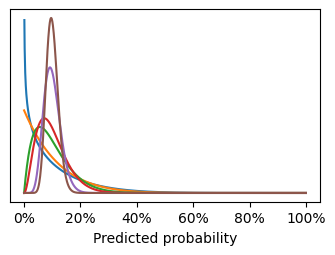

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), sharex=True)

for a in [.75,1,2,3,10,20]:
    distr = beta(a, a*9)
    x = np.linspace(0,1,1000)
    ax.plot(x, distr.pdf(x))

ax.set_yticks([])
ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels([f"{x:.0%}" for x in np.linspace(0,1,6)])
ax.set_xlabel("Predicted probability")

fig.savefig("possible_distributions.png", dpi=200, bbox_inches="tight")